<a href="https://colab.research.google.com/github/umbertoselva/Museum-FAQ-Chatbot/blob/main/Museum_FAQ_Chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MUSEUM FAQ CHATBOT

In this small Google Colab project I am going to build a chatbot that is able to answer questions based on a museum FAQ list.

I am going to use the following tools:
* ```sentence-transformers```
* ```elasticsearch``` 
* and a ```gradio``` user interface




The basic idea is the following:

I will use a sentence transformer to encode all of the FAQ questions beforehand. 

I will then store each FAQ question's encoded embeddings next to their corresponding answer in an Elasticsearch index.

I will then build a function that will similarly encode the user question as soon as the user inputs it via a user interface.

Finally, the same function will query the Elasticsearch index in order to retrieve the FAQ question embeddings that are more similar to the user question embeddings, and will then return the corresponding answer.




## TABLE OF CONTENTS

1. [Collecting the dataset](#s01)

2. [Saving the dataset in a CSV file](#s02)

3. [Getting the saved dataset from Google Drive](#s03)

4. [Setting up Elasticsearch](#s04)

5. [Setting up the Sentence Transformer](#s05)

6. [Encoding the FAQ questions](#s06)

7. [Populating the Elasticsearch index](#s07)

8. [The *encode_and_query* function](#s08)

9. [The Gradio user interface](#s09)

N.B. If you would like try out the chatbot yourself in Google Colab, you don't need to run the whole notebook from the beginning (i.e. you don't need to scrape the museum website again: the FAQ list might have changed by the time I have finished this project!), so you can skip straight to [point 3](#s03) and run the cells below from there.

Ok, let's start!

<a name="s01"></a>
## 1. COLLECTING THE DATASET

For this project we shall use the FAQ of the Stedelijk Museum of Amsterdam in the Netherlands.

As per June 30, 2020, they are available at https://www.stedelijk.nl/en/visit/faq and consist in a set of 68 questions, which seems like a reasonable dataset for our small project.

Let us first of all scrape the FAQ items from the website.

In [ ]:
import requests

In [ ]:
URL = "https://www.stedelijk.nl/en/visit/faq"
page = requests.get(URL)

In [ ]:
from bs4 import BeautifulSoup

In [ ]:
soup = BeautifulSoup(page.content, "html.parser")

In [ ]:
type(soup)

bs4.BeautifulSoup

This BeautifulSoup object contains the full HTML text of the webpage.

The portion containing the text of the FAQ questions and their corresponding answers is a series of blocks like the following:

```
<h3 class="faq__title">
<a aria-expanded="false" class="faq__button" data-handler="accessibleCollapser" data-target="#when-museum-open" data-target-class="js-is-expanded" href="https://www.stedelijk.nl/en/faq/when-museum-open">
                    What are the opening hours?
                </a>
</h3>
<div class="faq__answer">
<p>The Stedelijk is open daily from 10 am to 6 pm, 365 days a year, also during the holidays. </p>
</div>
```



Thus, the FAQ questions are contained in the HTML elements identified by the ```<h3 class="faq__title">``` tag.

We can use the BeautifulSourp ```.find_all()``` method to retrieve them.

In [ ]:
html_questions = soup.find_all("h3", {"class": "faq__title"})

In [ ]:
type(html_questions)

bs4.element.ResultSet

In [ ]:
html_questions[:2]

[<h3 class="faq__title">
 <a aria-expanded="false" class="faq__button" data-handler="accessibleCollapser" data-target="#when-museum-open" data-target-class="js-is-expanded" href="https://www.stedelijk.nl/en/faq/when-museum-open">
                     What are the opening hours?
                 </a>
 </h3>, <h3 class="faq__title">
 <a aria-expanded="false" class="faq__button" data-handler="accessibleCollapser" data-target="#does-museum-have-priority-lane" data-target-class="js-is-expanded" href="https://www.stedelijk.nl/en/faq/does-museum-have-priority-lane">
                     Does the museum have a Priority Lane?
                 </a>
 </h3>]

We can access the raw text as follows:

In [ ]:
html_questions[0].text

'\n\n                    What are the opening hours?\n                \n'

We need to do some cleaning:

In [ ]:
html_questions[0].text.strip()

'What are the opening hours?'

In [ ]:
html_questions[1].text.strip()

'Does the museum have a Priority Lane?'

Perfect. Let's make a list with the text of all the questions.

In [ ]:
question_list = [q.get_text().strip() for q in html_questions]

In [ ]:
question_list

['What are the opening hours?',
 'Does the museum have a Priority Lane?',
 'Is it possible to make a reservation?',
 'Do I need to book a ticket online before my visit to the museum?',
 'I have a Museum card (Museumkaart) or other valid admission ticket. Do I also need to buy an online ticket?',
 'Do I need to print out my ticket(s)?',
 'Can I purchase a Museum Card at the Stedelijk Museum?',
 'How much are tickets for students and children?',
 'I won’t be able to visit the museum. Can I give my ticket to someone else?',
 'I am a Member of the museum. Do I also need to buy an online ticket?',
 'Can I cancel the ticket I bought?',
 'I haven’t received my ticket. What should I do?',
 'I still have a question about my ticket',
 "I don't have access to internet and/or a smartphone. How can I reserve a ticket?",
 'Is the restaurant and/or the Zadelhoff café open?',
 'Does the museum have lockers, as well as a Cloakroom?',
 'When do the guided tours run, and how long are they?',
 'Can I leav

Let's do the same for the answers, which are contained in the HTML elements identified by the ```<div class="faq__answer">``` tag.

In [ ]:
html_answers = soup.find_all("div", {"class": "faq__answer"})

In [ ]:
html_answers[:5]

[<div class="faq__answer">
 <p>The Stedelijk is open daily from 10 am to 6 pm, 365 days a year, also during the holidays. </p>
 </div>, <div class="faq__answer">
 <p>Yes, the Priority Lane is available for Stedelijk Friends, Stedelijk VIP-card holders, and Stedelijk Annual Card holders. We are doing all that we can to regulate the flow of visitors and ensure their safety.</p>
 </div>, <div class="faq__answer">
 <p>It is possible to <a href="https://tickets.stedelijk.nl/Exhibitions/Register?id=b29ca5ad-709a-ea11-940c-005056b93cb9&amp;refresh=y">book</a> an online dayticket before you visit the museum. You can also buy a ticket directly at the register desk in the museum.</p>
 <p>Please read our info about your<a href="https://www.stedelijk.nl/en/visit/museumprotocol"> visit &amp; safety</a> before you visit. </p>
 </div>, <div class="faq__answer">
 <p>It is possible to book an <a href="https://tickets.stedelijk.nl/Exhibitions/Register?id=b29ca5ad-709a-ea11-940c-005056b93cb9&amp;refresh=

In [ ]:
answer_list = [q.get_text().strip() for q in html_answers]

In [ ]:
answer_list

['The Stedelijk is open daily from 10 am to 6 pm, 365 days a year, also during the holidays.',
 'Yes, the Priority Lane is available for Stedelijk Friends, Stedelijk VIP-card holders, and Stedelijk Annual Card holders. We are doing all that we can to regulate the flow of visitors and ensure their safety.',
 'It is possible to book an online dayticket before you visit the museum. You can also buy a ticket directly at the register desk in the museum.\nPlease read our info about your\xa0visit & safety before you visit.',
 'It is possible to book an online dayticket(s) before you visit the museum. You can also buy your ticket directly at the register desk in the museum.',
 "It is possible to book an online day ticket before you visit the museum. This also goes for visitors with a Museum card, another discount card, or valid entrance ticket*. If you already have a valid entrance ticket, select the option 'Entrance Museumkaart' or 'I already have an entrance ticket/card/voucher'. Be sure tha

Let's make sure that the number of questions and answers is the same.

In [ ]:
print(len(question_list))
print(len(answer_list))

68
68


Let's confirm that questions and answer match correctly.

In [ ]:
print(question_list[12])
print(answer_list[12])

I still have a question about my ticket
If you have questions about your ticket(s) that are not answered in this FAQ, email us at reserveringen@stedelijk.nl or call us during office hours: 020-5732911,
If you have other questions, go to www.stedelijk.nl/bezoeken or email us at info@stedelijk.nl


In [ ]:
print(question_list[50])
print(answer_list[50])

How can I pay?
We offer the following payment methods:

iDeal
Credit card
Cultuurkaart (VO/MBO)
Voucher (PO)

Unfortunately there is no option to pay by invoice.


Perfect!

<a name="s02"></a>
## 2. SAVING THE DATASET IN A CSV FILE

As the Stedelijk Museums's website might be updated any time, let us save the FAQ dataset that we have scraped, so that we are sure that we are always working with the same set of questions.

In [ ]:
# import pandas as pd
import pandas as pd

In [ ]:
df_faq = pd.DataFrame(list(zip(question_list, answer_list)), columns =['questions', 'answers'])
df_faq

,questions,answers
0,What are the opening hours?,The Stedelijk is open daily from 10 am to 6 pm...
1,Does the museum have a Priority Lane?,"Yes, the Priority Lane is available for Stedel..."
2,Is it possible to make a reservation?,It is possible to book an online dayticket bef...
3,Do I need to book a ticket online before my vi...,It is possible to book an online dayticket(s) ...
4,I have a Museum card (Museumkaart) or other va...,It is possible to book an online day ticket be...
...,...,...
63,Can we come by Museumpleinbus?,The Museumpleinbus brings groups of schools fr...
64,How long in advance do we need to be present?,You can sign in your group approximately 10 mi...
65,Is there a place where we can meet as a self-g...,You can meet up with your group at the followi...
66,Can we have lunch in the Stedelijk?,Food and drinks are only allowed in the Zadelh...


In [ ]:
df_faq.to_csv("stedelijkmuseum_faq_list.csv", sep='\t', encoding='utf-8')

Now the a csv file has been saved in our ```/content``` folder.



In [ ]:
!pwd

/content


In [ ]:
!ls

sample_data  stedelijkmuseum_faq_list.csv


<a name="s03"></a>
## 3. GETTING THE CSV FILE FROM GOOGLE DRIVE

Above we saved our dataset in a csv file.

After some tinkering with the chatbot, I realized that a few small changes to the dataset would have improved the chatbot's performance. Therefore I merged, erased, added and rephrased a bunch of questions.

I then saved the modified dataset on Google Drive.

Let us access that file and use this modified dataset from here on.

In [ ]:
# run this if you are starting to use this notebook from here
# otherwise you have already imported pandas above
import pandas as pd

In [ ]:
url = "https://drive.google.com/file/d/12BQXCL6ilv0s7i7Uzf0KrmqdP9ObASs3/view?usp=sharing"
file_id = url.split('/')[-2]
dwn_url = 'https://drive.google.com/uc?export=download&id=' + file_id
df = pd.read_csv(dwn_url, sep='\t', encoding='utf-8', index_col=[0])
df

,questions,answers
0,What are the opening hours? When is the museum...,The Stedelijk is open daily from 10 am to 6 pm...
1,Does the museum have a Priority Lane?,"Yes, the Priority Lane is available for Stedel..."
2,How can I buy a ticket? Can I buy my tickets o...,It is possible to book an online dayticket bef...
3,I have a Museum card (Museumkaart) or other va...,It is possible to book an online day ticket be...
4,Do I need to print out my ticket(s)?,It is enough to show your ticket on your smart...
...,...,...
64,Is there a place where we can meet as a self-g...,You can meet up with your group at the followi...
65,Can I have lunch in the museum?,Food and drinks are only allowed in the Zadelh...
66,What to do with delay or not being on time?,"In case of a delay, we kindly ask you to conta..."
67,How much are the tickets?,Please visit our website to view our current a...


Thus the modified dataset contains 69 Q&A pairs.

We now need to extract the texts of each question and answer from the Pandas dataframe and store them in two lists, which we will then use to populate the Elasticsearch index that we shall build in a moment.

In [ ]:
questions = df['questions'].to_list()
questions

['What are the opening hours? When is the museum open?',
 'Does the museum have a Priority Lane?',
 'How can I buy a ticket? Can I buy my tickets online?',
 'I have a Museum card (Museumkaart) or other valid admission ticket. Do I also need to buy an online ticket?',
 'Do I need to print out my ticket(s)?',
 'Can I purchase a Museum Card at the Stedelijk Museum?',
 'How much are tickets for students and children?',
 'I won’t be able to visit the museum. Can I give my ticket to someone else?',
 'I am a Member of the museum. Do I also need to buy an online ticket?',
 'Can I cancel the ticket I bought?',
 'I haven’t received my ticket. What should I do?',
 'I still have a question about my ticket',
 "I don't have access to internet and/or a smartphone. How can I reserve a ticket?",
 'Is there a restaurant or a café? When are the restaurant and café open?',
 'Does the museum have lockers, as well as a Cloakroom?',
 'Can I leave my suitcase or trolley?',
 'Can I visit the museum with a grou

In [ ]:
answers = df['answers'].to_list()
answers

['The Stedelijk is open daily from 10 am to 6 pm, 365 days a year, also during the holidays.',
 'Yes, the Priority Lane is available for Stedelijk Friends, Stedelijk VIP-card holders, and Stedelijk Annual Card holders. We are doing all that we can to regulate the flow of visitors and ensure their safety.',
 'It is possible to book an online dayticket before you visit the museum. You can also buy a ticket directly at the register desk in the museum.\nPlease read our info about your\xa0visit & safety before you visit.',
 "It is possible to book an online day ticket before you visit the museum. This also goes for visitors with a Museum card, another discount card, or valid entrance ticket*. If you already have a valid entrance ticket, select the option 'Entrance Museumkaart' or 'I already have an entrance ticket/card/voucher'. Be sure that you also bring your Museum card with you when you visit the museum.\xa0\n*Museumkaart, Friends of the Stedelijk Museum, Young Stedelijk Members, Rembra

<a name="s04"></a>
## 4. SETTING UP ELASTICSEARCH

In [ ]:
!pip install 'elasticsearch<7.14.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 356 kB 5.3 MB/s 


In [ ]:
! wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
! tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
! chown -R daemon:daemon elasticsearch-7.9.2

import os
from subprocess import Popen, PIPE, STDOUT

es_server = Popen(
    ["elasticsearch-7.9.2/bin/elasticsearch"], 
    stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1)  # as daemon
)
# wait until ES has started
! sleep 30

Let's test that the Elasticsearch server is running by querying the base endpoint (at localhost:9200).

In [ ]:
!curl -X GET "localhost:9200/"

{
  "name" : "992ba46d3aec",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "RE7Mc9P1QKKHWwqXcKJ8lA",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


Let's check that the correct processes are running.

In [ ]:
!ps -ef | grep elasticsearch

daemon       146      60 99 13:31 ?        00:00:39 /content/elasticsearch-7.9.2/jdk/bin/java -Xshare:auto -Des.networkaddress.cache.ttl=60 -Des.networkaddress.cache.negative.ttl=10 -XX:+AlwaysPreTouch -Xss1m -Djava.awt.headless=true -Dfile.encoding=UTF-8 -Djna.nosys=true -XX:-OmitStackTraceInFastThrow -XX:+ShowCodeDetailsInExceptionMessages -Dio.netty.noUnsafe=true -Dio.netty.noKeySetOptimization=true -Dio.netty.recycler.maxCapacityPerThread=0 -Dio.netty.allocator.numDirectArenas=0 -Dlog4j.shutdownHookEnabled=false -Dlog4j2.disable.jmx=true -Djava.locale.providers=SPI,COMPAT -Xms1g -Xmx1g -XX:+UseG1GC -XX:G1ReservePercent=25 -XX:InitiatingHeapOccupancyPercent=30 -Djava.io.tmpdir=/tmp/elasticsearch-15758344404987449848 -XX:+HeapDumpOnOutOfMemoryError -XX:HeapDumpPath=data -XX:ErrorFile=logs/hs_err_pid%p.log -Xlog:gc*,gc+age=trace,safepoint:file=logs/gc.log:utctime,pid,tags:filecount=32,filesize=64m -XX:MaxDirectMemorySize=536870912 -Des.path.home=/content/elasticsearch-7.9.2 -Des.path.

In [ ]:
# this import is only necessary if you have run the notebook from point 3
import requests

Let's check the server's health. (N.B. This check frequently fails. If so happens, please try again)

In [ ]:
# Make sure that the status is "green"
requests.get("http://localhost:9200/_cluster/health").json()

{'active_primary_shards': 0,
 'active_shards': 0,
 'active_shards_percent_as_number': 100.0,
 'cluster_name': 'elasticsearch',
 'delayed_unassigned_shards': 0,
 'initializing_shards': 0,
 'number_of_data_nodes': 1,
 'number_of_in_flight_fetch': 0,
 'number_of_nodes': 1,
 'number_of_pending_tasks': 0,
 'relocating_shards': 0,
 'status': 'green',
 'task_max_waiting_in_queue_millis': 0,
 'timed_out': False,
 'unassigned_shards': 0}

In [ ]:
# Check that no indexes exist at this stage
requests.get("http://localhost:9200/_cat/indices").text

''

Now we can instantiate an Elasticsearch client.

In [ ]:
from elasticsearch import Elasticsearch

In [ ]:
es = Elasticsearch('http://localhost:9200')

Now we can create an index. Let's call it ```faq_index```.

During index creation we can define the "mapping", which is equivalent to defining a table schema at the moment of a database table creation.

We shall define three fields:

* **embedding**: a dense vector field to store the question embeddings. The model that we shall use below generates 768-dimensional embeddings, so let's set that here too.
* **question**: a text field to store the text of the FAQ question from which the embeddings were produced.
* **answer**: a text field to store the text of the corresponsing answer. 

In [ ]:
es.indices.create('faq_index', 
                  ignore=404, 
                  body={
                      "mappings": {
                          "properties": {
                              "embedding": {
                                  "type": "dense_vector",
                                  "dims": 768,
                                  },
                              "question": {
                                  "type": "text",},
                              "answer": {
                                  "type": "text",
                                  }
                            }
                      }
                  }
)

{'acknowledged': True, 'index': 'faq_index', 'shards_acknowledged': True}

Let us make sure that the index has been created.

In [ ]:
requests.get("http://localhost:9200/_cat/indices").text

'yellow open faq_index YIR92wIcSJ-huMR0SQcQiQ 1 1 0 0 208b 208b\n'

<a name="s05"></a>
## 5. SETTING UP THE SENTENCE TRANSFORMER

We are going to use the ```sentence-transformers``` library to leverage a pretrained model to encode our FAQ questions and the user question.

We shall use the ```all-mpnet-base-v2``` model. This  is one of the newer models available with the ```sentence-transformers``` library. The latter was originally developed around SBERT, an improved, faster, more scalable version of BERT based on a siamese architecture that can produce sentence-level embeddings, rather than just token-level embeddings.

According to https://www.sbert.net/docs/pretrained_models.html
the ```all-mpnet-base-v2``` model features a max sequence length of	384, and embeddings with a dimension of 768.

In [ ]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.5 MB/s 
     |████████████████████████████████| 4.4 MB 28.8 MB/s 
     |████████████████████████████████| 1.2 MB 43.2 MB/s 
     |████████████████████████████████| 101 kB 10.7 MB/s 
     |████████████████████████████████| 596 kB 49.3 MB/s 
     |████████████████████████████████| 6.6 MB 40.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=1b71bd4fbc0856026f5cb5ddda0a972223d2fddbcc4e939da4881553bdc38def
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
sentence_transformer = SentenceTransformer("all-mpnet-base-v2")

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

<a name="s06"></a>
## 6. ENCODING THE FAQ QUESTIONS

Now we can proceed to encode our FAQ questions.

The ```.encode()``` method will return a matrix of shape (69, 768), i.e. an array of 69 arrays (the embeddings) each consisting of 768 floats.

In [ ]:
q_emb = sentence_transformer.encode(questions)

In [ ]:
q_emb.shape

(69, 768)

In [ ]:
type(q_emb)

numpy.ndarray

In [ ]:
q_emb

array([[-0.01773045,  0.01513828, -0.03280092, ..., -0.02755269,
        -0.05604987,  0.00660459],
       [ 0.00509801,  0.0513333 , -0.03815203, ..., -0.06402185,
        -0.00664513, -0.01568183],
       [-0.01749739,  0.03756651, -0.0278425 , ..., -0.00137984,
        -0.01713154, -0.01403491],
       ...,
       [ 0.00790073, -0.01039814, -0.02201495, ...,  0.0119863 ,
         0.05366091, -0.03144356],
       [-0.01190495, -0.05455469, -0.0094575 , ..., -0.01135369,
        -0.04598646,  0.0144234 ],
       [ 0.02014207,  0.01429683, -0.02203955, ..., -0.02006016,
        -0.00936383, -0.02161353]], dtype=float32)

In [ ]:
type(q_emb[0])

numpy.ndarray

In [ ]:
q_emb[0]

array([-1.77304503e-02,  1.51382824e-02, -3.28009166e-02,  7.06112757e-02,
       -8.74032527e-02,  6.92547532e-04,  2.02003568e-02,  2.54637115e-02,
       -2.88220588e-02, -2.07929383e-03, -2.97217946e-02, -3.74775827e-02,
        1.95506625e-02, -7.19693378e-02, -1.27671724e-02,  5.53101301e-03,
        1.79819446e-02, -5.21014212e-03, -5.45990132e-02, -3.97999771e-02,
       -8.05584639e-02,  8.37062299e-03, -7.01295286e-02, -8.85832869e-03,
        3.23801190e-02, -3.42475884e-02, -3.16322371e-02,  6.09318912e-03,
        4.27878946e-02, -8.95835087e-03, -4.48268466e-02, -1.99740436e-02,
        3.97995487e-03,  3.51808034e-02,  1.12893065e-06, -2.96681039e-02,
        3.31372209e-03,  4.52590175e-02, -1.02975452e-02, -1.82640273e-02,
        2.94346903e-02,  4.67889011e-02, -1.13698393e-02,  5.80632733e-03,
        2.77804807e-02, -6.47760779e-02,  4.05465290e-02, -4.65951450e-02,
       -1.94476265e-02,  4.50295508e-02, -6.79708365e-03,  1.82734150e-02,
        3.53489295e-02,  

However, we need to extract these floats by turning our array of arrays into a list of lists, which we will later iterate to populate our Elasticsearch index.

Thus, let us create a list of lists called ```question_embeddings```, and then let us turn each single array of 768 floats into a list of floats, and append it to our ```question_embeddings``` list of lists.



In [ ]:
question_embeddings = []

for i in range(len(q_emb)):
  question_embeddings.append(q_emb[i].tolist())

In [ ]:
type(question_embeddings)

list

In [ ]:
type(question_embeddings[0])

list

In [ ]:
question_embeddings[0]

[-0.01773045025765896,
 0.01513828244060278,
 -0.03280091658234596,
 0.07061127573251724,
 -0.08740325272083282,
 0.0006925475317984819,
 0.02020035684108734,
 0.025463711470365524,
 -0.02882205881178379,
 -0.002079293830320239,
 -0.02972179464995861,
 -0.037477582693099976,
 0.019550662487745285,
 -0.07196933776140213,
 -0.012767172418534756,
 0.005531013011932373,
 0.017981944605708122,
 -0.005210142116993666,
 -0.054599013179540634,
 -0.03979997709393501,
 -0.08055846393108368,
 0.008370622992515564,
 -0.07012952864170074,
 -0.008858328685164452,
 0.0323801189661026,
 -0.034247588366270065,
 -0.03163223713636398,
 0.006093189120292664,
 0.04278789460659027,
 -0.008958350867033005,
 -0.044826846569776535,
 -0.01997404359281063,
 0.003979954868555069,
 0.03518080338835716,
 1.1289306485195993e-06,
 -0.029668103903532028,
 0.003313722088932991,
 0.0452590174973011,
 -0.010297545231878757,
 -0.018264027312397957,
 0.02943469025194645,
 0.04678890109062195,
 -0.011369839310646057,
 0.005

In [ ]:
question_embeddings[0][0]

-0.01773045025765896

In [ ]:
type(question_embeddings[0][0])

float

<a name="s07"></a>
## 7. POPULATING THE ELASTICSEARCH INDEX

Now we are ready to populate our Elasticsearch index according to the mapping pattern that we created earlier:


*   Embeddings
*   Question
*   Answer

for each FAQ Q&A pair

In [ ]:
# we now have three lists
# 1) question_embeddings: a list of 69 lists each with 768 embeddings (floats)
# 2) questions: a list of 69 questions (strings)
# 3) answers: a list of 69 answers (strings)

for i in range(len(questions)):

  # get the corresponding embedding, Q text and A text for each Q&A pair
  data = {
      "embedding" : question_embeddings[i], 
      "question" : questions[i],
      "answer" : answers[i]
  }

  # populate the Elasticsearch index
  es.index(index="faq_index", body=data)


<a name="s08"></a>
## 8. THE ENCODE-AND-QUERY FUNCTION

We are now ready to build a function that 
* reads in the user question;
* encodes it in the same way as we have previously encoded our FAQ questions;
* then, by querying the Elasticsearch index, retrieves the FAQ question whose embedding is most similar to the embedding of the user question;
* finally, it returns the corresponding answer that was stored with it.

Let's make a first version of such a function for illustrative purposes.

Let's set the query to return 5 results by setting the ```size``` parameter.

In [ ]:
ENCODER_BOOST = 10

def encode_and_query_v1(user_question, size: int=5):

  # generate the user question embedding
  embedding = sentence_transformer.encode(user_question).tolist()

  # query the Elasticsearch index
  es_result = es.search(
      index="faq_index", # the index where we saved our embeddings, Qs and As
      body={
            "from": 0,
            "size": size, # the num of expected query results
            "_source": ["question", "answer"],
            "query": {
                "script_score": {
                    "query": {
                        "match": {
                            "question": user_question
                        }
                    },
                    "script": {
                        "source": """
                            (cosineSimilarity(params.query_vector, "embedding") + 1.0)
                            * params.encoder_boost + _score
                        """,
                        "params": {
                            "query_vector": embedding,
                            "encoder_boost": ENCODER_BOOST,
                        },
                    },
                }
            }
      }
  )

  return es_result

Let's try it out and see what the return object looks like.

In [ ]:
encode_and_query_v1("Can I cancel my ticket?")

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'hits': {'hits': [{'_id': 'AtnRtIEB1vUWtH8XF8LA',
    '_index': 'faq_index',
    '_score': 27.60449,
    '_source': {'answer': 'We don’t refund money for purchased tickets. Tickets are valid for twelve months after the date of purchase. If you can’t use your ticket on the date you reserved, you can easily book a new ticket on the date of your preference through our ticketshop. Choose the date and then the option "I already have a valid entrance ticket".',
     'question': 'Can I cancel the ticket I bought?'},
    '_type': '_doc'},
   {'_id': 'NNnRtIEB1vUWtH8XG8LJ',
    '_index': 'faq_index',
    '_score': 21.453812,
    '_source': {'answer': 'You can cancel or reschedule a tour from the first day of the previous month of the booking. For example, when you’ve booked your tour for the 14th of June, you can cancel or reschedule this until the first of May.',
     'question': 'Can I cancel or reschedule a planned tour?'

In [ ]:
results = encode_and_query_v1("Can I cancel my ticket?")

In [ ]:
type(results)

dict

The object returned by the Elasticsearch query is a dict with four keys (```'_shards'```, ```'hits'```, ```'timed_out'``` and ```'took'```):

```
{
  '_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
  'hits: {
    'hits': [WE ARE INTERESTED IN THIS LIST],
    'max_score': 27.696018,
    'total': {'relation': 'eq', 'value': 40}}
    }
  'timed_out': False,
  'took': 429}
}
```

In turn, the 'hits' key corresponds to a value which is also a dict. This dict features three keys: ```'hits'``` (yet again), ```'max_score'``` and ```'total'```. 

What we are interested in is this more embedded ```'hits'``` key, whose corresponding value is a list of all the matches returned by our query. In this case 5 hits (cf. the ```size``` parameter we set in our function)

Let's zoom in:

In [ ]:
results['hits']

{'hits': [{'_id': 'AtnRtIEB1vUWtH8XF8LA',
   '_index': 'faq_index',
   '_score': 27.60449,
   '_source': {'answer': 'We don’t refund money for purchased tickets. Tickets are valid for twelve months after the date of purchase. If you can’t use your ticket on the date you reserved, you can easily book a new ticket on the date of your preference through our ticketshop. Choose the date and then the option "I already have a valid entrance ticket".',
    'question': 'Can I cancel the ticket I bought?'},
   '_type': '_doc'},
  {'_id': 'NNnRtIEB1vUWtH8XG8LJ',
   '_index': 'faq_index',
   '_score': 21.453812,
   '_source': {'answer': 'You can cancel or reschedule a tour from the first day of the previous month of the booking. For example, when you’ve booked your tour for the 14th of June, you can cancel or reschedule this until the first of May.',
    'question': 'Can I cancel or reschedule a planned tour?'},
   '_type': '_doc'},
  {'_id': 'BNnRtIEB1vUWtH8XF8L4',
   '_index': 'faq_index',
   '_

In [ ]:
type(results['hits'])

dict

In [ ]:
type(results['hits']['hits'])

list

In [ ]:
len(results['hits']['hits'])

5

In [ ]:
results['hits']['hits']

[{'_id': 'AtnRtIEB1vUWtH8XF8LA',
  '_index': 'faq_index',
  '_score': 27.60449,
  '_source': {'answer': 'We don’t refund money for purchased tickets. Tickets are valid for twelve months after the date of purchase. If you can’t use your ticket on the date you reserved, you can easily book a new ticket on the date of your preference through our ticketshop. Choose the date and then the option "I already have a valid entrance ticket".',
   'question': 'Can I cancel the ticket I bought?'},
  '_type': '_doc'},
 {'_id': 'NNnRtIEB1vUWtH8XG8LJ',
  '_index': 'faq_index',
  '_score': 21.453812,
  '_source': {'answer': 'You can cancel or reschedule a tour from the first day of the previous month of the booking. For example, when you’ve booked your tour for the 14th of June, you can cancel or reschedule this until the first of May.',
   'question': 'Can I cancel or reschedule a planned tour?'},
  '_type': '_doc'},
 {'_id': 'BNnRtIEB1vUWtH8XF8L4',
  '_index': 'faq_index',
  '_score': 20.900906,
  '_

The hits, i.e. our query results, are orded by decreasing order according to the ```'_score'``` parameter (i.e. the result of the similarity score calculation).

Let's grab the first 'hit' from this list, i.e. the one with the highest score.

In [ ]:
results['hits']['hits'][0]

{'_id': 'AtnRtIEB1vUWtH8XF8LA',
 '_index': 'faq_index',
 '_score': 27.60449,
 '_source': {'answer': 'We don’t refund money for purchased tickets. Tickets are valid for twelve months after the date of purchase. If you can’t use your ticket on the date you reserved, you can easily book a new ticket on the date of your preference through our ticketshop. Choose the date and then the option "I already have a valid entrance ticket".',
  'question': 'Can I cancel the ticket I bought?'},
 '_type': '_doc'}

Now we can easily see that the item return is another dict, with the following structure:

```
{
  '_id': ...,
  '_index': ...,
  '_score': ...,
  '_source': ...,
  '_type': ...
}
```

The answer text that we are looking for is found in the value corresponding to the ```_source``` key.


In [ ]:
results['hits']['hits'][0]['_source']

{'answer': 'We don’t refund money for purchased tickets. Tickets are valid for twelve months after the date of purchase. If you can’t use your ticket on the date you reserved, you can easily book a new ticket on the date of your preference through our ticketshop. Choose the date and then the option "I already have a valid entrance ticket".',
 'question': 'Can I cancel the ticket I bought?'}

The above is also a dict featuring two keys: ```'answer'``` and ```'question'```.

We can finally grab the raw text of the retrieved answer:

In [ ]:
results['hits']['hits'][0]['_source']['answer']

'We don’t refund money for purchased tickets. Tickets are valid for twelve months after the date of purchase. If you can’t use your ticket on the date you reserved, you can easily book a new ticket on the date of your preference through our ticketshop. Choose the date and then the option "I already have a valid entrance ticket".'

Let us rewrite our *encode_and_query* function so that it returns precisely the text of the top answer only.

Since we will only want to output the top answer, we can also set the ```size``` parameter to 1, so that the query itself only returns the answer with the highest score.

In [ ]:
ENCODER_BOOST = 10

def encode_and_query_v2(user_question, size: int=1):

  # generate the user question embedding
  embedding = sentence_transformer.encode(user_question).tolist()

  # es query
  es_result = es.search(
      index="faq_index",
      body={
            "from": 0,
            "size": size,
            "_source": ["question", "answer"],
            "query": {
                "script_score": {
                    "query": {
                        "match": {
                            "question": user_question
                        }
                    },
                    "script": {
                        "source": """
                            (cosineSimilarity(params.query_vector, "embedding") + 1.0)
                            * params.encoder_boost + _score
                        """,
                        "params": {
                            "query_vector": embedding,
                            "encoder_boost": ENCODER_BOOST,
                        },
                    },
                }
            }
      }
  )

  return es_result['hits']['hits'][0]['_source']['answer']

In [ ]:
answ = encode_and_query_v2("Can I cancel my ticket?")
print(answ)

We don’t refund money for purchased tickets. Tickets are valid for twelve months after the date of purchase. If you can’t use your ticket on the date you reserved, you can easily book a new ticket on the date of your preference through our ticketshop. Choose the date and then the option "I already have a valid entrance ticket".


In [ ]:
answ = encode_and_query_v2("What time can I organize a group visit?")
print(answ)

At present, we offer set timed tickets on Mondays, Tuesdays and Thursdays. You can choose from the following time slots:
10.15 -11.45 am
12.00 - 1.30 pm
2.15 - 3.45 pm
4.00 - 5.30 pm
When you make a reservation, you will be shown the time slots that are available. If not enough slots are free, you can divide your group over different time slots.
You can arrive at the group entrance at the Paulus Potterstraat about 10 minutes before the start of your visit and use the group cloakroom (if there is enough room).


<a name="s09"></a>
## THE USER INTERFACE

We shall use the ```gradio``` library to display a user interface in this notebook.




In [ ]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.1 MB 5.1 MB/s 
     |████████████████████████████████| 84 kB 3.2 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 212 kB 38.3 MB/s 
     |████████████████████████████████| 140 kB 57.2 MB/s 
     |████████████████████████████████| 272 kB 55.1 MB/s 
     |████████████████████████████████| 2.3 MB 43.2 MB/s 
     |████████████████████████████████| 54 kB 3.0 MB/s 
     |████████████████████████████████| 57 kB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 41.4 MB/s 
     |████████████████████████████████| 94 kB 3.5 MB/s 
     |████████████████████████████████| 144 kB 75.9 MB/s 
     |████████████████████████████████| 271 kB 69.3 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 80 kB 8.8 MB/s 
     |████████████████████████████████| 68 kB 


Gradio allows us to create a chatbot interface simply by setting the ```outputs=``` parameter to ```["chatbot", "state"]```.

The ```input=``` is set to feed our function two arguments:

*   the ```"text"``` of the question submitted by the user (a string);
*   the ```"state"```, which, if desired, can keep track of the conversation history.

Thus, we need to rewrite our *embed_and_query*  function so that it can accept these two arguments.

Gradio then expects our function to output the updated conversation history as a list of tuples, each containing the user question and the answer, updated at each iteration by appending the new tuple (question and answer) to the list.

This system is intended to allow you to retrieve an answer not solely on the basis of the user question, but also on account of the preceding interaction. However, we are not going to use this feature here. Therefore, I will simply append a new tuple with user question and retrieved answer to the ```history``` list at each call, and return this list as required for the Gradio interface to work.

In [ ]:
ENCODER_BOOST = 10

def encode_and_query(user_question, history=[], size: int=1):

  # generate the user question embedding
  embedding = sentence_transformer.encode(user_question).tolist()

  # es query
  es_result = es.search(
      index="faq_index", # the index where we stored embeddings, Qa & As
      body={
            "from": 0,
            "size": size, # the number of expected query results
            "_source": ["question", "answer"],
            "query": {
                "script_score": {
                    "query": {
                        "match": {
                            "question": user_question
                        }
                    },
                    "script": {
                        "source": """
                            (cosineSimilarity(params.query_vector, "embedding") + 1.0)
                            * params.encoder_boost + _score
                        """,
                        "params": {
                            "query_vector": embedding,
                            "encoder_boost": ENCODER_BOOST,
                        },
                    },
                }
            }
      }
  )

  response = es_result['hits']['hits'][0]['_source']['answer']

  # update conversation history
  history.append((user_question, response))

  return history, history

In [ ]:
import gradio as gr

In [ ]:
# In the basic "chatbot" type interface
# the user messages will be displayed in Orange
# and the chatbot responses in Grey

# Note that the Textbox in which to enter the user question
# will have a heading that corresponds 
# to the first argument of our function (i.e. "user_question")

gr.Interface(fn=encode_and_query,
             inputs=["text", "state"],
             outputs=["chatbot", "state"], 
             allow_flagging="never").launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://10268.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7f657b32bd50>,
 'http://127.0.0.1:7860/',
 'https://10268.gradio.app')

The result should look like this:

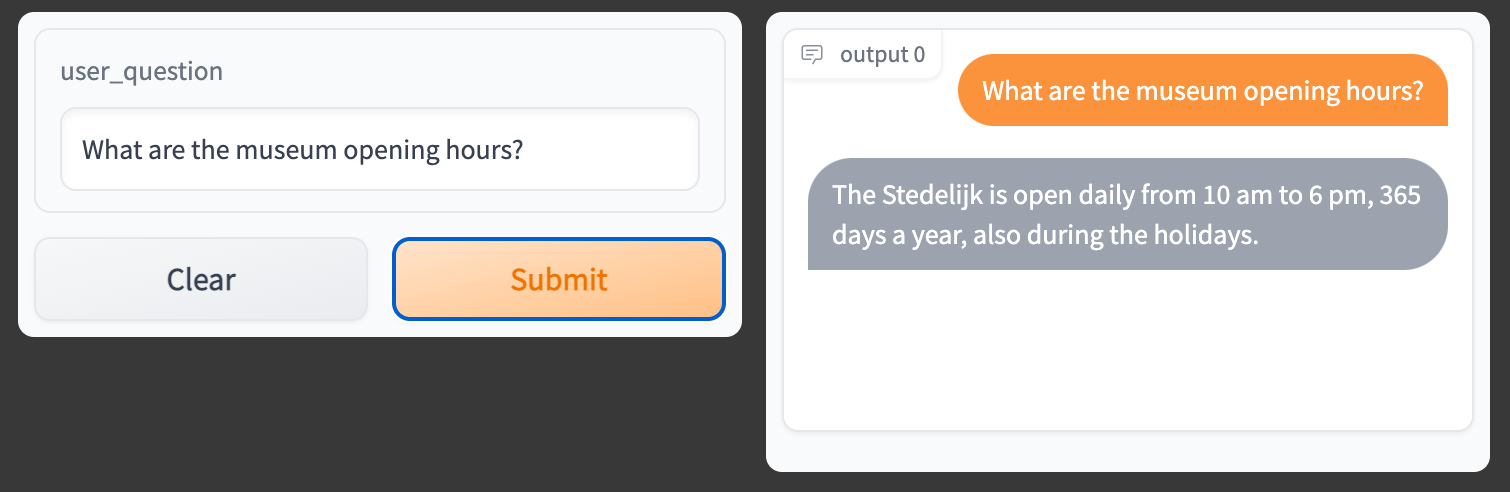